In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hakgyunhong","key":"fa00a5f73a60f1439d8cccfeff32f22b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d nicholasjhana/energy-consumption-generation-prices-and-weather

  0% 0.00/3.81M [00:00<?, ?B/s]
100% 3.81M/3.81M [00:00<00:00, 145MB/s]


In [5]:
!unzip energy-consumption-generation-prices-and-weather.zip
!ls

Archive:  energy-consumption-generation-prices-and-weather.zip
  inflating: energy_dataset.csv      
  inflating: weather_features.csv    
energy-consumption-generation-prices-and-weather.zip  sample_data
energy_dataset.csv				      weather_features.csv
kaggle.json


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [22]:
def load_data(col=None, path="/content/energy_dataset.csv",verbose=False):
 df=pd.read_csv(path)
 if col is not None:
   df=df[col]
 if verbose:
   print(df.head())
 return df
print("Multivariate Sample")
multivar_df = load_data(['time', 'total load actual', 'price actual'], verbose=True)
  

Multivariate Sample
                        time  total load actual  price actual
0  2015-01-01 00:00:00+01:00            25385.0         65.41
1  2015-01-01 01:00:00+01:00            24382.0         64.92
2  2015-01-01 02:00:00+01:00            22734.0         64.48
3  2015-01-01 03:00:00+01:00            21286.0         59.32
4  2015-01-01 04:00:00+01:00            20264.0         56.04


In [23]:
df = load_data(col=["total load forecast","total load actual"])

df_filled=df.interpolate("linear")
mm = MinMaxScaler()
df_scaled = mm.fit_transform(df_filled)
df_prep = pd.DataFrame(df_scaled, columns=df.columns)
y_true = df_prep["total load actual"]
y_pred_forecast = df_prep["total load forecast"]

# persistence 1 day
y_preds_persistance_1_day = y_true.shift(24).dropna()
persistence_1_day_mae = tf.keras.losses.MAE(y_true[y_preds_persistance_1_day.index], y_preds_persistance_1_day).numpy()
persistence_1_day_mape = tf.keras.losses.MAPE(np.maximum(y_true[y_preds_persistance_1_day.index],1e-5),np.maximum(y_preds_persistance_1_day,1e-5)).numpy()

In [24]:
# persistence 3 day
shift_dfs = list()
for i in range(1,4):
  shift_dfs.append(pd.Series(y_true.shift(24*i), name=f"d{i}"))

y_persistance_3d = pd.concat(shift_dfs, axis=1).dropna()
y_persistance_3d["avg"] = (y_persistance_3d["d1"] +y_persistance_3d["d2"] +y_persistance_3d["d3"])/3

d3_idx = y_persistance_3d.index
persistence_3day_avg_mae = tf.keras.losses.MAE(y_true[d3_idx], y_persistance_3d['avg']).numpy()
persistence_3day_avg_mape = tf.keras.losses.MAPE(np.maximum(y_true[d3_idx], 1e-5), np.maximum(y_persistance_3d['avg'], 1e-5)).numpy()

ref_error = pd.DataFrame({
    "Method":["TSO Forecast", "Persistence 1 Day", "Persistence 3 Day Avg"],
    "MAE": [tf.keras.losses.MAE(y_true, y_pred_forecast).numpy(),
            persistence_1_day_mae,
            persistence_3day_avg_mae],
    "MAPE":[tf.keras.losses.MAPE(np.maximum(y_true,1e-5), np.maximum(y_pred_forecast,1e-5)).numpy(),
            persistence_1_day_mape,
            persistence_3day_avg_mape]},
            index=[i for i in range(3)])
print("\nSummary of Baseline Errors")
print(ref_error)
print(f"\nAverage error in MW for TSO Forecast {round(df['total load forecast'].mean()*ref_error.iloc[0,1],2)}")



Summary of Baseline Errors
                  Method       MAE       MAPE
0           TSO Forecast  0.015456   5.472781
1      Persistence 1 Day  0.106903  65.951647
2  Persistence 3 Day Avg  0.115176  84.151898

Average error in MW for TSO Forecast 443.76


# Preparing Data

In [25]:
def clean_data(series):
  series_filled = series.interpolate(method='linear')
  return series_filled

def min_max_scale(dataframe):
  mm=MinMaxScaler()
  return mm.fit_transform(dataframe)

In [26]:
#from re import M
def make_time_features(series):
  times=series.apply(lambda x: x.split('+')[0])
  datetimes = pd.DatetimeIndex(times)

  hours = datetimes.hour.values
  day = datetimes.dayofweek.values
  months = datetimes.month.values

  hour = pd.Series(hours, name='hours')
  dayofw = pd.Series(day, name='dayofw')
  month = pd.Series(months, name='months')

  return hour, dayofw, month
hour, day, month = make_time_features(multivar_df.time)
print("Hours")
print(hour.head())
print("Day of Week")
print(day.head())
print("Months")
print(month.head())

Hours
0    0
1    1
2    2
3    3
4    4
Name: hours, dtype: int64
Day of Week
0    3
1    3
2    3
3    3
4    3
Name: dayofw, dtype: int64
Months
0    1
1    1
2    1
3    1
4    1
Name: months, dtype: int64


In [27]:
def split_data(series, train_fraq, test_len=8760):
  test_slice = len(series)-test_len

  test_data = series[test_slice:]
  train_val_data = series[:test_slice]

  train_size=int(len(train_val_data)*train_fraq)

  train_data=train_val_data[:train_size]
  val_data = train_val_data[train_size:]

  return train_data, val_data, test_data

multivar_df = clean_data(multivar_df)

hours, day, months = make_time_features(multivar_df.time)
multivar_df = pd.concat([multivar_df.drop(['time'], axis=1), hours, day, months], axis=1)

multivar_df = min_max_scale(multivar_df)
train_multi, val_multi,  test_multi = split_data(multivar_df, train_fraq=0.65, test_len=8760)

print("Multivarate Datasets")
print(f"Train Data Shape:{train_multi.shape}")
print(f"Val Data Shape:{val_multi.shape}")
print(f"Test Data Shape:{test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test{np.any(np.isnan(test_multi))}")

Multivarate Datasets
Train Data Shape:(17097, 5)
Val Data Shape:(9207, 5)
Test Data Shape:(8760, 5)
Nulls In Train False
Nulls In Validation False
Nulls In TestFalse


# Windowing the Dataset

In [28]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_beffer, multi_var=False, expand_dims=False):
  """
  Create a windowed tensorflow dataset
  """

  # Size
  window = n_steps + n_horizon

  # Create the initial tensor dataset
  if expand_dims:
    ds = tf.expand_dims(data,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(ds)
  else:
    ds = tf.data.Dataset.from_tensor_slices(data)
  #Create window fuction shifting the data by the prediction length
  ds = ds.window(window, shift=n_horizon, drop_remainder=True)

  #flatten the dataset and batch into the widnow size
  ds = ds.flat_map(lambda x:x.batch(window))
  ds = ds.shuffle(shuffle_buffer)

  #create
  if multi_var:
    ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:,:1]))
  else:
    ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
  
  ds = ds.batch(batch_size).prefetch(1)

  return ds

tf.random.set_seed(42)
n_steps= 72
n_horizon = 24
batch_size=1
shuffle_buffer = 100

ds = window_dataset(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer,multi_var=True)

print('Example sample shapes')
for idx,(x,y) in enumerate(ds):
  print("x=",x.numpy().shape)
  print("y=",y.numpy().shape)
  break

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Example sample shapes
x= (1, 72, 5)
y= (1, 24, 1)


# Dataset Loading Function

In [29]:
def build_dataset(train_fraq=0.65,
                  n_steps=24*30,
                  n_horizon=24,
                  batch_size=256,
                  shuffle_buffer=500,
                  expand_dims=False,
                  multi_var=False):
  tf.random.set_seed(23)

  if multi_var:
    data = load_data(col=['time', 'total load actual','price actual'])
    hours, day, months = make_time_features(data.time)
    data = pd.concat([data.drop(['time'], axis=1), hours, day, months], axis=1)
  else:
    data = load_data(col=['total load actual'])
  data = clean_data(data)

  if multi_var:
    mm = MinMaxScaler()
    data = mm.fit_transform(data)
  train_data, val_data,test_data = split_data(data,train_fraq=train_fraq, test_len=8760)

  train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
  val_ds=window_dataset(val_data,n_steps,n_horizon,batch_size,shuffle_buffer,multi_var=multi_var,expand_dims=expand_dims)
  test_ds=window_dataset(test_data,n_steps,n_horizon,batch_size,shuffle_buffer,multi_var=multi_var,expand_dims=expand_dims)

  print(f"Prediction lookback n_steps: {n_steps}")
  print(f"Prediction horizon (n_horizon): {n_horizon}")
  print(f"Batch Size: {batch_size}")
  print("Datasets:")
  print(train_ds.element_spec)

  return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = build_dataset(multi_var=True)


Prediction lookback n_steps: 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


# Model Configuration

> Define a set of model configurations so that we can call and run each model in the same way.

In [30]:
def get_params(multivar=False):
  lr = 3e-4
  n_steps=24*30
  n_horizon=24
  if multivar:
    n_features=5
  else:
    n_features=1
  return n_steps, n_horizon, n_features, lr

model_configs=dict()

def cfg_model_run(model, history, test_ds):
  return {"model":model, "history":history, "test_ds":test_ds}

def run_model(model_name, model_func, model_configs, epochs):
  n_steps, n_horizon, n_features, lr = get_params(multivar=True)
  train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)
  model = model_func(n_steps, n_horizon, n_features, lr=lr)
  model_hist = model.fit(train_ds, validation_data = val_ds, epochs=epochs)
  model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
  return test_ds

In [33]:
def dnn_model(n_steps, n_horizon, n_features,lr):
  tf.keras.backend.clear_session()

  model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(n_steps,n_features)),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(n_horizon)
  ],name='dnn')

  loss=tf.keras.losses.Huber()
  optimizer=tf.keras.optimizers.Adam(lr=lr)
  model.compile(loss=loss, optimizer='adam', metrics=['mae'])

  return model
dnn=dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 128)               460928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 24)                3096      
                                                                 
Total params: 480,536
Trainable params: 480,536
Non-trainable p

In [35]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
  tf.keras.backend.clear_session()
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(64,kernel_size=6,activation='relu',input_shape=(n_steps, n_features)),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64,kernel_size=3,activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(n_horizon)
  ], name="CNN")

  loss = tf.keras.losses.Huber()
  optimizer = tf.keras.optimizers.Adam(lr=lr)

  model.compile(loss=loss, optimizer='adam', metrics=['mae'])
  return model
cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 11328)             0         
                                                                 
 dropout (Dropout)           (None, 11328)             0       

In [36]:
def lstm_model(n_steps, n_horizon, n_features, lr):
  tf.keras.backend.clear_session()
  
  model=tf.keras.models.Sequential([
      tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps,n_features), return_sequences=True),
      tf.keras.layers.LSTM(48,activation='relu',return_sequences=False),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(n_horizon)
  ],name='lstm')

  loss=tf.keras.losses.Huber()
  optimizer=tf.keras.optimizers.Adam(lr=lr)
  model.compile(loss=loss, optimizer='adam', metrics=['mae'])

  return model
lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 72)           22464     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 24)                3096   

In [39]:
def lstm_cnn_model(n_steps, n_horizon,n_features,lr):
  tf.keras.backend.clear_session()
  model=tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(64,kernel_size=6,activation='relu', input_shape=(n_steps,n_features)),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(64,kernel_size=3,activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.LSTM(72,activation='relu', return_sequences=True),
      tf.keras.layers.LSTM(48,activation='relu', return_sequences=False),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(n_horizon)
  ], name="lstm_cnn")

  loss = tf.keras.losses.Huber()
  optimizer=tf.keras.optimizers.Adam(lr=lr)

  model.compile(loss=loss, optimizer='adam', metrics=['mae'])
  return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 715, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 357, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 355, 64)           12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 177, 64)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 177, 72)           39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [40]:
def lstm_cnn_skip_model(n_steps, n_horizon,n_features,lr):
  tf.keras.backend.clear_session()

  inputs = tf.keras.layers.Input(shape=(n_steps, n_features), name='main')
  conv1=tf.keras.layers.Conv1D(64,kernel_size=6,activation='relu')(inputs)
  max_pool_1=tf.keras.layers.MaxPooling1D(2)(conv1)
  conv2=tf.keras.layers.Conv1D(64,kernel_size=3,activation='relu')(max_pool_1)
  max_pool_2=tf.keras.layers.MaxPooling1D(2)(conv2)
  lstm_1=tf.keras.layers.LSTM(72,activation='relu',return_sequences=True)(max_pool_2)
  lstm_2=tf.keras.layers.LSTM(48,activation='relu',return_sequences=False)(lstm_1)
  flatten=tf.keras.layers.Flatten()(lstm_2)

  skip_flatten=tf.keras.layers.Flatten()(inputs)
  concat=tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
  drop_1=tf.keras.layers.Dropout(0.3)(concat)
  dense_1=tf.keras.layers.Dense(128,activation='relu')(drop_1)
  drop_2=tf.keras.layers.Dropout(0.3)(dense_1)
  output=tf.keras.layers.Dense(n_horizon)(drop_2)

  model=tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')

  loss=tf.keras.losses.Huber()
  optimizer=tf.keras.optimizers.Adam(lr=lr)
  model.compile(loss=loss, optimizer='adam', metrics=['mae'])
  return model
lstm_skip=lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 720, 5)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 715, 64)      1984        ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 357, 64)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 355, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                          

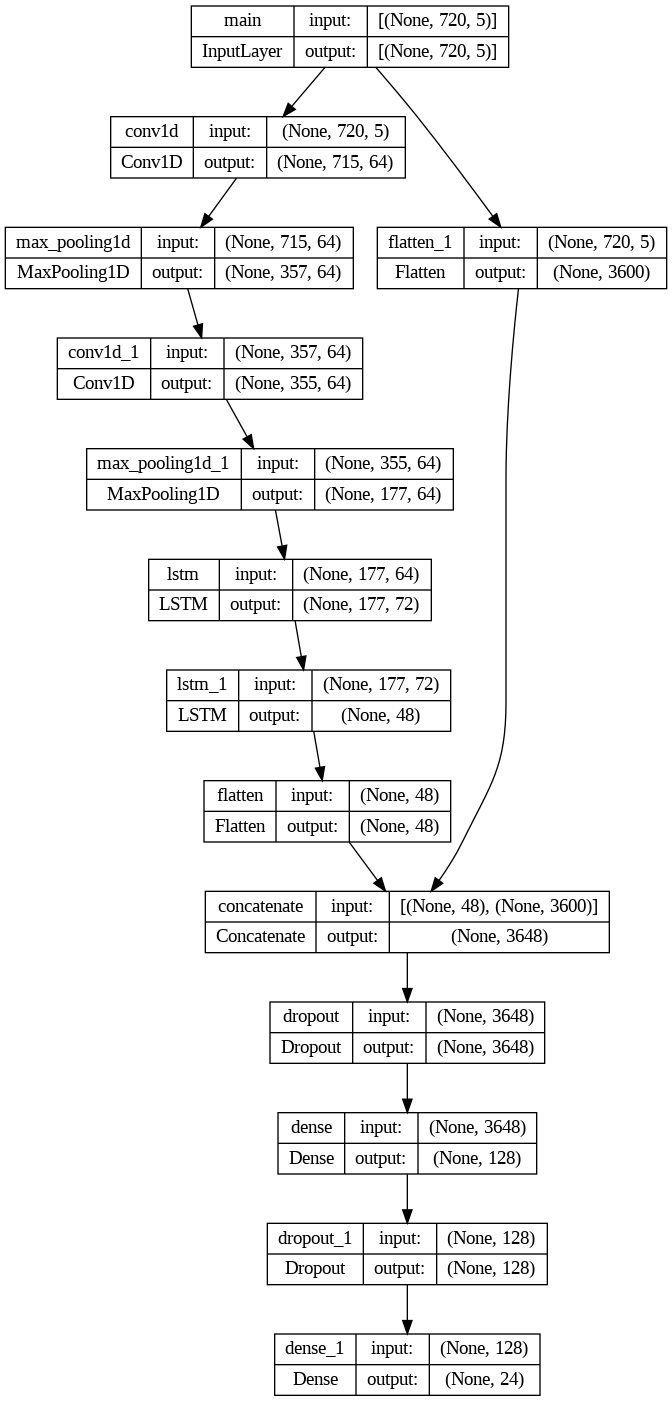

In [42]:
tf.keras.utils.plot_model(lstm_skip,show_shapes=True)

# Train Model

In [43]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Prediction lookback n_steps: 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


Epoch 1/150
3/3 [==============================] - 4s 807ms/step - loss: 0.3516 - mae: 0.7062 - val_loss: 0.0752 - val_mae: 0.3231
Epoch 2/150
3/3 [==============================] - 1s 344ms/step - loss: 0.0954 - mae: 0.3562 - val_loss: 0.0840 - val_mae: 0.3426
Epoch 3/150
3/3 [==============================] - 1s 485ms/step - loss: 0.0781 - mae: 0.3250 - val_loss: 0.0745 - val_mae: 0.3086
Epoch 4/150
3/3 [==============================] - 1s 471ms/step - loss: 0.0660 - mae: 0.2973 - val_loss: 0.0635 - val_mae: 0.2898
Epoch 5/150
3/3 [==============================] - 1s 518ms/step - loss: 0.0586 - mae: 0.2757 - val_loss: 0.0607 - val_mae: 0.2812
Epoch 6/150
3/3 [==============================] - 2s 531ms/step - loss: 0.0505 - mae: 0.2562 - val_loss: 0.0602 - val_mae: 0.2773
Epoch 7/150
3/3 [==============================] - 1s 316ms/step - loss: 0.0450 - mae: 0.2389 - val_loss: 0.0516 - val_mae: 0.2616
Epoch 8/150
3/3 [==============================] - 1s 324ms/step - loss: 0.0420 - m

Prediction lookback n_steps: 720
Prediction horizon (n_horizon): 24
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
3/3 [==============================] - 4s 737ms/step - loss: 0.3540 - mae: 0.7039 - val_loss: 0.1275 - val_mae: 0.4026
Epoch 2/150
3/3 [==============================] - 3s 736ms/step - loss: 0.1344 - mae: 0.4224 - val_loss: 0.1512 - val_mae: 0.4700
Epoch 3/150
3/3 [==============================] - 3s 765ms/step - loss: 0.1089 - mae: 0.3865 - val_loss: 0.0827 - val_mae: 0.3435
Epoch 4/150
3/3 [==============================] - 2s 625ms/step - loss: 0.0566 - mae: 0.2785 - val_loss: 0.0616 - val_mae: 0.2748
Epoch 5/150
3/3 [==============================] - 2s 643ms/step - loss: 0.0370 - mae: 0.2196 - val_loss: 0.0586 - val_mae: 0.2805
Epoch 6/150
3/3 [==============================] - 2s 681ms/step - loss: 0.0321 - mae: 0.1988 - val_loss: 0.0508 - val_mae

Epoch 1/150
3/3 [==============================] - 15s 4s/step - loss: 0.1164 - mae: 0.4414 - val_loss: 0.1226 - val_mae: 0.4506
Epoch 2/150
3/3 [==============================] - 10s 3s/step - loss: 0.1022 - mae: 0.4105 - val_loss: 0.1115 - val_mae: 0.4208
Epoch 3/150
3/3 [==============================] - 10s 3s/step - loss: 0.0850 - mae: 0.3678 - val_loss: 0.0940 - val_mae: 0.3709
Epoch 4/150
3/3 [==============================] - 9s 3s/step - loss: 0.0617 - mae: 0.3001 - val_loss: 0.0684 - val_mae: 0.3003
Epoch 5/150
3/3 [==============================] - 10s 3s/step - loss: 0.0486 - mae: 0.2520 - val_loss: 0.0586 - val_mae: 0.2766
Epoch 6/150
3/3 [==============================] - 11s 3s/step - loss: 0.0361 - mae: 0.2164 - val_loss: 0.0565 - val_mae: 0.2747
Epoch 7/150
3/3 [==============================] - 10s 3s/step - loss: 0.0308 - mae: 0.2002 - val_loss: 0.0543 - val_mae: 0.2691
Epoch 8/150
3/3 [==============================] - 11s 4s/step - loss: 0.0264 - mae: 0.1842 - val_

Epoch 1/150
3/3 [==============================] - 8s 2s/step - loss: 0.1154 - mae: 0.4371 - val_loss: 0.1122 - val_mae: 0.4216
Epoch 2/150
3/3 [==============================] - 4s 1s/step - loss: 0.0904 - mae: 0.3730 - val_loss: 0.0791 - val_mae: 0.3345
Epoch 3/150
3/3 [==============================] - 5s 1s/step - loss: 0.0647 - mae: 0.2920 - val_loss: 0.0602 - val_mae: 0.2848
Epoch 4/150
3/3 [==============================] - 5s 2s/step - loss: 0.0447 - mae: 0.2404 - val_loss: 0.0525 - val_mae: 0.2619
Epoch 5/150
3/3 [==============================] - 5s 2s/step - loss: 0.0354 - mae: 0.2137 - val_loss: 0.0458 - val_mae: 0.2528
Epoch 6/150
3/3 [==============================] - 4s 1s/step - loss: 0.0301 - mae: 0.1953 - val_loss: 0.0430 - val_mae: 0.2480
Epoch 7/150
3/3 [==============================] - 4s 1s/step - loss: 0.0250 - mae: 0.1780 - val_loss: 0.0409 - val_mae: 0.2371
Epoch 8/150
3/3 [==============================] - 5s 1s/step - loss: 0.0216 - mae: 0.1660 - val_loss: 0

Epoch 1/150
3/3 [==============================] - 9s 2s/step - loss: 0.6195 - mae: 1.0053 - val_loss: 0.0792 - val_mae: 0.3267
Epoch 2/150
3/3 [==============================] - 4s 1s/step - loss: 0.1179 - mae: 0.4095 - val_loss: 0.1283 - val_mae: 0.4648
Epoch 3/150
3/3 [==============================] - 5s 1s/step - loss: 0.1155 - mae: 0.4352 - val_loss: 0.1251 - val_mae: 0.4436
Epoch 4/150
3/3 [==============================] - 5s 2s/step - loss: 0.1141 - mae: 0.4228 - val_loss: 0.1237 - val_mae: 0.4484
Epoch 5/150
3/3 [==============================] - 6s 2s/step - loss: 0.1122 - mae: 0.4262 - val_loss: 0.1186 - val_mae: 0.4377
Epoch 6/150
3/3 [==============================] - 5s 2s/step - loss: 0.1096 - mae: 0.4121 - val_loss: 0.1054 - val_mae: 0.4010
Epoch 7/150
3/3 [==============================] - 5s 1s/step - loss: 0.1079 - mae: 0.4019 - val_loss: 0.1139 - val_mae: 0.4240
Epoch 8/150
3/3 [==============================] - 5s 2s/step - loss: 0.1053 - mae: 0.4062 - val_loss: 0

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

# Evaluation of Train/Valid Results

Loss Curves


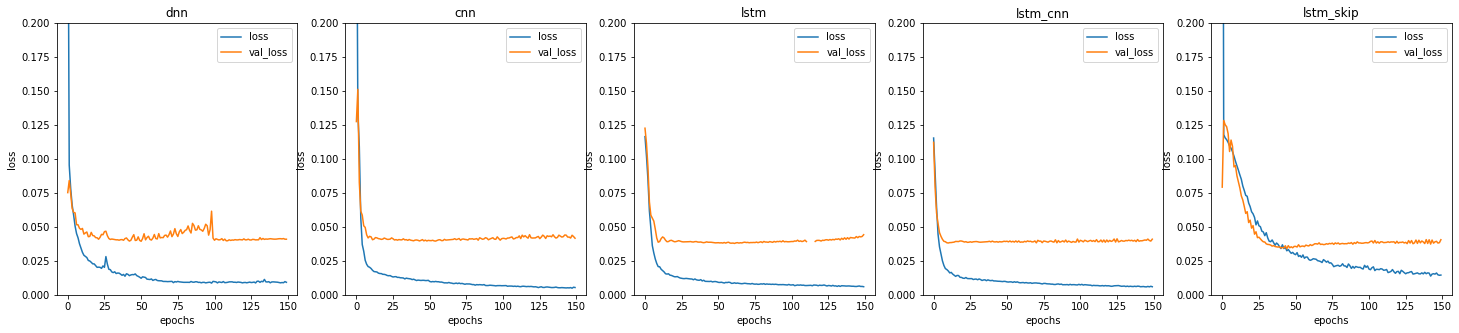

In [46]:
legend=list()

fig, axs = plt.subplots(1,5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
  ax.plot(val['history'].history[metric])
  ax.plot(val['history'].history[f'val_{metric}'])
  ax.set_title(key)
  ax.legend([metric, f'val_{metric}'])
  ax.set_xlabel('epochs')
  ax.set_ylabel(metric)
  ax.set_ylim([0,upper])

for (key,val), ax in zip(model_configs.items(), axs.flatten()):
  plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


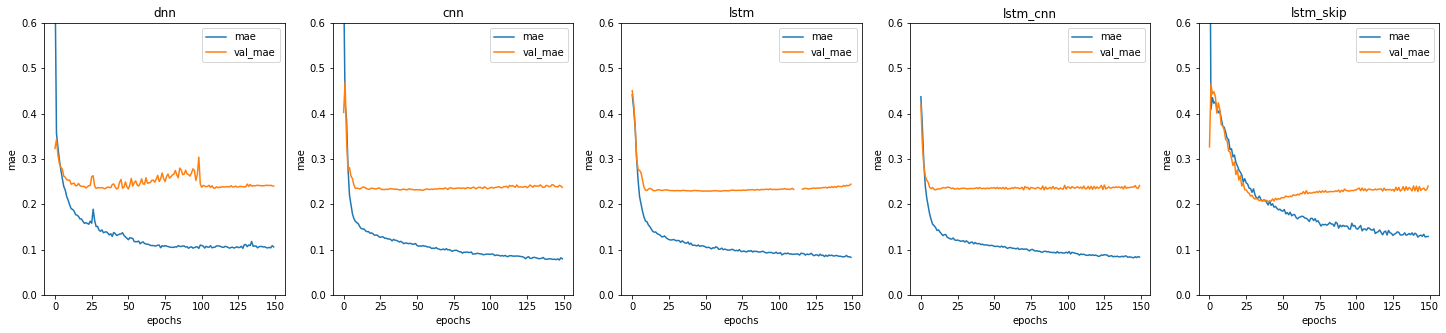

In [47]:
print("MAE Curves")

fig,axs = plt.subplots(1,5, figsize=(25,5))

for (key,val),ax in zip(model_configs.items(),axs.flatten()):
  plot_graphs('mae',val,ax,0.6)

## Test Result

In [48]:
names = list()
performance = list()

for key, value in model_configs.items():
  names.append(key)
  mae=value['model'].evaluate(value['test_ds'])
  performance.append(mae[1])

performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * df['total load forecast'].mean()
print(performance_df)

2/2 [==============================] - 1s 157ms/step - loss: 0.0071 - mae: 0.0927
                mae     error_mw
dnn        0.106355  3053.688752
cnn        0.078976  2267.575532
lstm       0.093115  2673.538593
lstm_cnn   0.085489  2454.567781
lstm_skip  0.092706  2661.786358


## Visualizing Prediction

2/2 [==============================] - 1s 146ms/step
First Two Weeks of Predictions


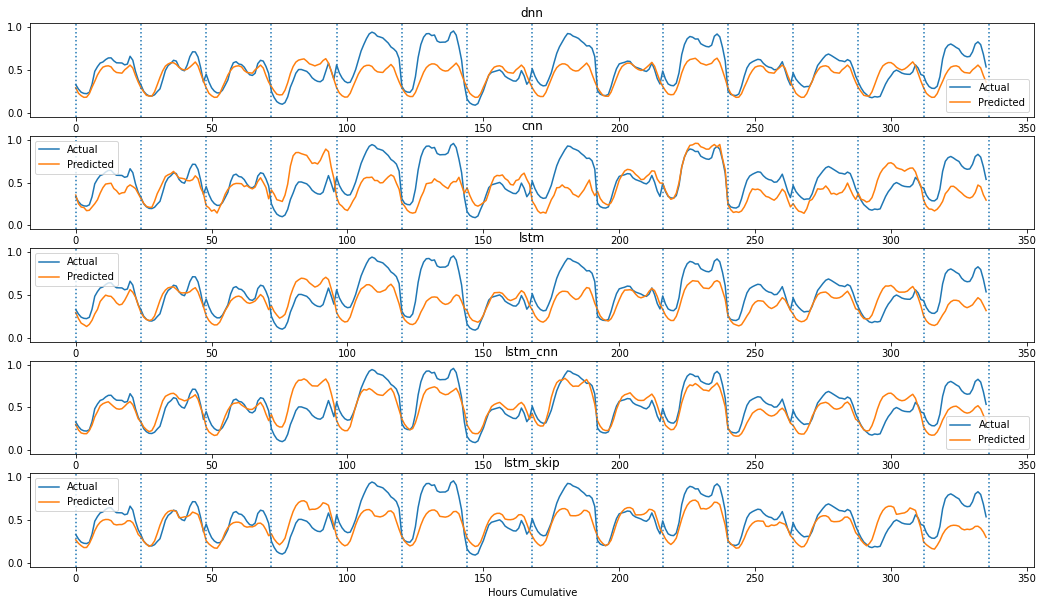

In [50]:
fig, axs = plt.subplots(5,1, figsize=(18,10))
days=14

vline = np.linspace(0,days*24,days+1)

for (key,val),ax in zip(model_configs.items(), axs):
  test = val['test_ds']
  preds = val['model'].predict(test)

  xbatch, ybatch = iter(test).get_next()

  ax.plot(ybatch.numpy()[:days].reshape(-1))
  ax.plot(preds[:days].reshape(-1))
  ax.set_title(key)
  ax.vlines(vline,ymin=0,ymax=1, linestyle='dotted', transform=ax.get_xaxis_transform())
  ax.legend(["Actual","Predicted"])

plt.xlabel("Hours Cumulative")
print("First Two Weeks of Predictions")